In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import cmath
import math
from scipy.optimize import fmin, minimize
from astropy import units as u
from scipy.interpolate import RegularGridInterpolator
import matplotlib.pyplot as plt
import copy
%matplotlib inline

from PIL import Image

In [3]:
class data:
    u: float
    v: float
    phase: float
    amp: float
    sigma: float
    vis_data: complex
    def __init__(self, u, v, phase, amp, sigma):
        self.u = u
        self.v = v
        self.phase = phase
        self.amp = amp
        self.sigma = sigma
        self.vis_data = amp * np.exp(1j * math.radians(phase))

    def __repr__(self):
        return f"[u: {self.u}, v: {self.v}]"

    def __str__(self):
        return f"[u: {self.u}, v: {self.v}]"

In [4]:
# Assumption image is 80px by 80px => 6400 variables
def loss(image, data_list: list[data], coords, p = 2, reg_weight = 1, FOV = 1): #Ask about u.rad
    error_sum = 0
    vis_images = interpolate(image, coords, FOV)

    for i in range(len(data_list)):
        vis_data = data_list[i][1]
        vis_image = vis_images[i]
        error = (abs(vis_image-vis_data)) ** 2
        error_sum += error
    
    return error_sum

In [5]:
# Assumption image is 80x80 pixels
# Pass in array of u,v coords then return array of interpolated values
def interpolate(image, coords, FOV):
    """
    image is a 80x80 pixel image that represents our reconstructed image
    coords is a list of u,v coordinates that we obtained from our data
    FOV is the Field of view from the telescopes. For the EHT data, our FOV is 100 micro ascs.
    """

    ft_image = np.fft.fftshift(np.fft.fft2(image))

    k_FOV = (1)/FOV

    kx = np.fft.fftshift(np.fft.fftfreq(ft_image.shape[0], d = 1/(k_FOV*ft_image.shape[0])))
    ky = np.fft.fftshift(np.fft.fftfreq(ft_image.shape[1], d = 1/(k_FOV*ft_image.shape[1])))

    interp_real = RegularGridInterpolator((kx, ky), ft_image.real, bounds_error=False, method="linear")
    interp_imag = RegularGridInterpolator((kx, ky), ft_image.imag, bounds_error=False, method="linear")

    real = interp_real(coords)
    imag = interp_imag(coords)

    return real + imag * 1j

In [6]:
# p is the exponent of the regularizing terms
# The smaller p the more sensitive it is to noise
# TSV = Total Squared Variation
def calc_regularizer(image: np.array, tsv=False, p=None):
    if tsv and p == None:
        raise Exception("p value not set")
    reg = 0
    if tsv:
        image_lshift = np.copy(image, subok=True)
        image_lshift = np.roll(image_lshift, -1,axis=1)
        image_lshift[:,-1] = 0
        image_upshift = np.copy(image, subok=True)
        image_upshift = np.roll(image_upshift, -1, axis=0)
        image_upshift[-1] = 0

        term_1 = np.power(np.absolute(np.subtract(image_lshift, image)),p)
        term_2 = np.power(np.absolute(np.subtract(image_upshift, image)),p)
        reg = np.sum(np.add(term_1,term_2))
    return reg

In [7]:
def process_data(data_df):
    coords = []
    data_list = []
    for i in range(len(data_df)):
        data_list.append(data(data_df.loc[i, 'U(lambda)'], data_df.loc[i, 'V(lambda)'], data_df.loc[i, 'Iphase(d)'], data_df.loc[i, 'Iamp(Jy)'], data_df.loc[i, 'Isigma(Jy)']))
        coords.append([data_df.loc[i, 'U(lambda)'], data_df.loc[i, 'V(lambda)']])
    coords = np.array(coords)
    return coords, data_list

In [8]:
def read_data(filename: str()):
    df = pd.read_csv(filename)
    return df

In [9]:
n = 80

a = np.linspace(-50, 50, n)
x, y = np.meshgrid(a, a)

k = np.fft.fftfreq(n, a[1]-a[0])
kx, ky = np.meshgrid(k, k)

def Gaussian(sigma, x0=0, y0=0):
    dx = x - x0
    dy = y - y0
    return np.exp(-0.5 * (dx*dx + dy*dy) / (sigma * sigma))

def ring(nn=0.01):
    return np.maximum(Gaussian(10, *randpos(1)) - Gaussian(8, *randpos(1)), 0) + nn * noise(2)

def noise(alpha):
    white_noise = np.random.rand(n, n)-0.5 + 1j*(np.random.rand(n, n)-0.5)
    power_law = np.power(kx*kx + ky*ky + 1e-300, -0.5 * alpha)
    power_law[0,0] = 0
    img  = np.real(np.fft.ifft2(white_noise * power_law))
    img += np.min(img)
    img /= np.max(img)
    return img

def randpos(scale=1):
    x = (np.random.rand() - 0.5) * 2 * scale
    y = (np.random.rand() - 0.5) * 2 * scale
    return x, y

(-0.5, 79.5, 79.5, -0.5)

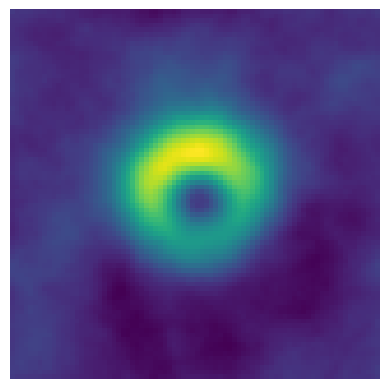

In [10]:
#sample = ring() # Sample is 80 by 80
#np.savetxt("data.csv", sample, delimiter=",")
sample = np.loadtxt("data.csv", delimiter=",")
plt.figure()
plt.imshow(sample)
plt.axis('off')

(-0.5, 79.5, 79.5, -0.5)

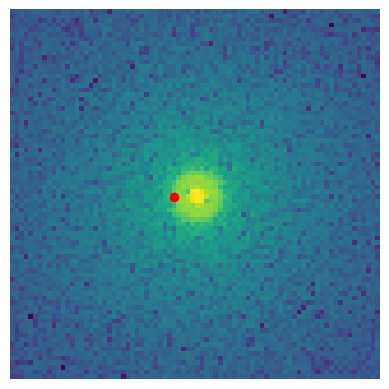

In [31]:
ft_image = np.fft.fftshift(np.fft.fft2(sample))
plt.figure()
plt.imshow(np.log(np.abs(ft_image)))
plt.scatter([35],[40], color = "red")
plt.axis('off')

In [46]:
coords = []
data_list = []
for i in range(25):
    coords.append((int(np.random.rand()*10-5), int(np.random.rand()*10-5)))
    data_list.append((coords[i],ft_image[coords[i][0]+40][coords[i][1]+40]))

In [47]:
data_list

[((2, 0), (32.21849839699435+21.12122492192262j)),
 ((0, -4), (-16.666885639518576-3.717810642145843j)),
 ((0, 0), (-130.7977532545254+0j)),
 ((-3, 2), (18.046523876827383-2.5971752659760363j)),
 ((4, 0), (-21.092399479624063+7.428119584083978j)),
 ((-4, -3), (11.503853927875113-0.807378246118693j)),
 ((0, 4), (-16.666885639518576+3.717810642145843j)),
 ((3, 3), (-16.073815037740104-0.5318295817126556j)),
 ((-4, -4), (-4.213479534444887-1.4852988761164416j)),
 ((3, 0), (9.345246066663234-12.763088241472762j)),
 ((0, 0), (-130.7977532545254+0j)),
 ((0, 2), (45.25288306329196-3.200855947045237j)),
 ((1, -3), (-21.359637680230904-2.2933676872188915j)),
 ((-3, -2), (18.59914527451261+7.6023610122723255j)),
 ((-3, 4), (10.97997772948687+0.8737280514156963j)),
 ((0, -4), (-16.666885639518576-3.717810642145843j)),
 ((2, -1), (-10.778371094544593-11.568945106256791j)),
 ((-4, -1), (16.740754111448133-2.3097206184670487j)),
 ((1, -2), (-24.68242315194496-6.537735288980759j)),
 ((-2, -2), (-15.3

Loads Image and data

In [36]:
loss(sample*0.1,data_list,coords)

35114.90608276224

In [37]:
emp = np.zeros((80,80))
loss(emp,data_list,coords)

43351.73590464473

In [49]:
loss_arr = np.zeros((len(sample),len(sample[0])))
for i in range(len(sample)):
    image_1 = np.roll(sample, i, axis=1) # Right shifts
    for j in range(len(sample[i])):
        image_2 = np.roll(image_1, j, axis = 0) # Up shifts
        loss_arr[i][j] = loss(image_2, data_list, coords, reg_weight=0)

In [39]:
loss_arr.shape

(80, 80)

In [40]:
shifted = np.roll(sample, 40, axis=1)
shifted2 = np.roll(shifted, 40, axis=0)

(-0.5, 79.5, 79.5, -0.5)

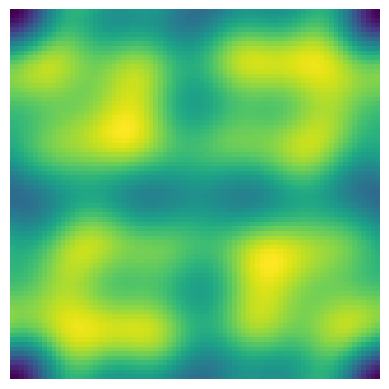

In [50]:
plt.figure()
plt.imshow(loss_arr)
plt.axis('off')

In [20]:
negative_arr = []
positive_arr = []
for i in range(80):
    negative_arr.append(loss_arr[i][79-i])
    positive_arr.append(loss_arr[i][i])

In [21]:
positive_arr

[0.0,
 68.49236048504999,
 265.4694167706388,
 578.7802350641274,
 994.5156124992511,
 1495.3350030892109,
 2059.010778616679,
 2660.737174193751,
 3280.729020372813,
 3904.9536955645976,
 4518.440814692188,
 5107.756176017728,
 5667.50545401498,
 6194.879200125261,
 6686.088255926061,
 7134.024287518852,
 7532.258387144642,
 7876.358467207227,
 8156.429779731225,
 8357.771741138778,
 8467.90498631528,
 8477.090722366525,
 8378.16769022338,
 8163.8833095845985,
 7832.613963975407,
 7392.815174583465,
 6858.486193914931,
 6247.055936607337,
 5580.313012781927,
 4884.381001231258,
 4187.032866625403,
 3511.885513122994,
 2879.1825277459448,
 2306.591031919354,
 1807.6068151659608,
 1388.5598367515581,
 1050.471220747247,
 791.4916172439257,
 610.4476522751204,
 504.7080955768667,
 469.7522597068406,
 504.7080955768668,
 610.4476522751204,
 791.4916172439257,
 1050.4712207472471,
 1388.5598367515586,
 1807.6068151659622,
 2306.5910319193554,
 2879.1825277459448,
 3511.8855131229957,
 4187

In [43]:
x = []
y = []
for i in coords:
    x.append(i[0])
    y.append(i[1])

(-4.4, 4.4, -3.35, 4.35)

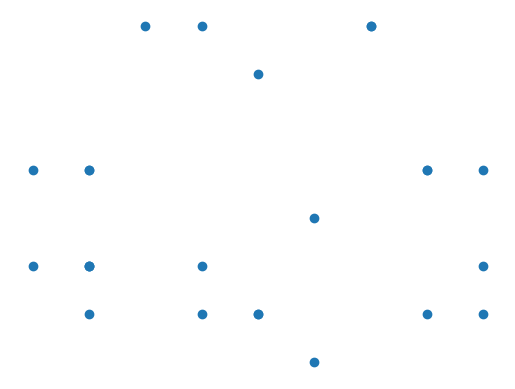

In [44]:
plt.figure()
plt.scatter(x, y)
plt.axis('off')